In [40]:
### Important notice : this notebook works under @dft_for_sm conda env...

In [41]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
import dft_descriptors.prepocessing as pp
from dft_descriptors import numbering_CO as nb

In [58]:
#### determine if AX is RMgX, Boronic, Zincate, Lithien, imidazole, tetrazole, CO2, isocyanate ####
def ax_type(list_lig):
    lig_type = []
    for smi in list_lig:
        m = Chem.MolFromSmiles(smi)
        # RMgX
        if m.HasSubstructMatch(Chem.MolFromSmiles('C[Mg]Br')):
            typ = 'Magnesien'
        elif m.HasSubstructMatch(Chem.MolFromSmiles('C[Mg]I')):
            typ = 'Magnesien'
        elif m.HasSubstructMatch(Chem.MolFromSmiles('C[Mg]Cl')):
            typ = 'Magnesien'
        
        # Boronic
        elif m.HasSubstructMatch(Chem.MolFromSmiles('OBO')):
            typ = 'Boronic'
            
        # Lithien
        elif m.HasSubstructMatch(Chem.MolFromSmiles('C[Li]')):
            typ = 'Lithien'
            
        # Zincate
        elif m.HasSubstructMatch(Chem.MolFromSmiles('[Zn]')):
            typ = 'Zincate'
            
        # Aluminate
        elif m.HasSubstructMatch(Chem.MolFromSmiles('C[Al](C)C')):
            typ = 'Aluminate'
            
        # CO2
        elif m.HasSubstructMatch(Chem.MolFromSmiles('O=C=O')):
            typ = 'CO2'
        
        # Isocyanate
        elif m.HasSubstructMatch(Chem.MolFromSmiles('N=C=O')):
            typ = 'Isocyanate'
            
        # Tetrazole
        elif m.HasSubstructMatch(Chem.MolFromSmiles('N=C=O')):
            typ = 'Isocyanate'
            
        # Imidazole
        elif m.HasSubstructMatch(Chem.MolFromSmiles('N1=CNC=C1')):
            typ = 'Imidazole'
        elif m.HasSubstructMatch(Chem.MolFromSmiles('N1=COC=C1')):
            typ = 'Imidazole'
            
        # Phosphorus
        elif m.HasSubstructMatch(Chem.MolFromSmiles('P=O')):
            typ = 'Phosphine Oxide'
            
        # Silicate
        elif m.HasSubstructMatch(Chem.MolFromSmiles('[Si](OCC)(OCC)OCC')):
            typ = 'Silicate'
        
        # Amines
        elif m.HasSubstructMatch(Chem.MolFromSmiles('CN[H]')):
            typ = 'Amines'
            
        
        else:
            typ = 'other'
        lig_type.append(typ)
    return lig_type

def smi_L_type(smi):
    m = Chem.MolFromSmiles(smi)
    if m.HasSubstructMatch(Chem.MolFromSmiles('N[C]N')):
        typ = 'NHC'
    elif m.HasSubstructMatch(Chem.MolFromSmiles('P')):
        typ = 'Phos'
        if len(m.GetSubstructMatches(Chem.MolFromSmiles('P'))) == 2:
            typ = 'DiPhos'
    else:
        typ = 'other'
    return typ



#### PHOS ####
def number_Phos(smi):
    m = Chem.MolFromSmiles(smi)
    i = 1
    for c in m.GetSubstructMatches(Chem.MolFromSmiles('PC')): 
        for at in m.GetAtoms():
            a = at.GetIdx()
            if a in c and at.GetSymbol() == 'P':
                nb.reset_atom_map(m, 0)
                at.SetAtomMapNum(0)
            elif a in c and at.GetSymbol() != 'P':
                nb.reset_atom_map(m, i)
                at.SetAtomMapNum(i)
                i += 1 
    return m






#### DIPHOS ####
def number_DiPhos(smi):
    m = Chem.MolFromSmiles(smi)
    ip = 0
    ic1 = 2
    ic2 = 5
    for c in m.GetSubstructMatches(Chem.MolFromSmiles('P')): 
        for at in m.GetAtoms():
            a = at.GetIdx()
            if a in c and at.GetSymbol() == 'P':
                nb.reset_atom_map(m, ip)
                at.SetAtomMapNum(ip)
                ip += 1
                
    for c in m.GetSubstructMatches(Chem.MolFromSmiles('PC')): 
        at_map_c = [m.GetAtoms()[i].GetAtomMapNum() for i in c]
        for at in m.GetAtoms():
            a = at.GetIdx()
            if a in c:
                if at.GetSymbol() != 'P':
                    if 0 in at_map_c:
                        nb.reset_atom_map(m, ic1)
                        at.SetAtomMapNum(ic1)
                        ic1 += 1
                    elif 1 in at_map_c:
                        nb.reset_atom_map(m, ic2)
                        at.SetAtomMapNum(ic2)
                        ic2 += 1
    return m


#### NHC ####
def number_NHC(smi):
    m = Chem.MolFromSmiles(smi)
    if m.HasSubstructMatch(Chem.MolFromSmiles('N1[C]NCC1')):
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('N[C]N')):
                nb.reset_atom_map(m, 0)
                m.GetAtoms()[c[0]].SetAtomMapNum(0)

        iN = 1
        for N in m.GetSubstructMatches(Chem.MolFromSmiles('N')):
            if N[0] in m.GetSubstructMatch(Chem.MolFromSmiles('N[C]N')):
                nb.reset_atom_map(m, iN)
                m.GetAtoms()[N[0]].SetAtomMapNum(iN)
                iN +=1 
        
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('C1N[C]NC1')):
                if m.GetAtoms()[c[0]].GetAtomMapNum() > 0:
                    nb.reset_atom_map(m, iN)
                    m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                    iN +=1
      
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('C1N(C)[C]N(C)C1')):
                if m.GetAtoms()[c[0]].GetAtomMapNum() >= 5:
                    nb.reset_atom_map(m, iN)
                    m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                    iN +=1
            
    elif m.HasSubstructMatch(Chem.MolFromSmiles('N1[C]NC=C1')): 
        num = len(m.GetSubstructMatches(Chem.MolFromSmiles('C1=CN[C]N1')))
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('N[C]N')):
                nb.reset_atom_map(m, 0)
                m.GetAtoms()[c[0]].SetAtomMapNum(0)

        iN = 1
        for N in m.GetSubstructMatches(Chem.MolFromSmiles('N')):
            if num ==1 :
                if N[0] in m.GetSubstructMatch(Chem.MolFromSmiles('N[C]N')):
                    nb.reset_atom_map(m, iN)
                    m.GetAtoms()[N[0]].SetAtomMapNum(iN)
                    iN +=1 
            else:
                if N[0] in find_good_match(m, 0, 'N[C]N'):
                    nb.reset_atom_map(m, iN)
                    m.GetAtoms()[N[0]].SetAtomMapNum(iN)
                    iN +=1 
                 
        
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if num ==1 :
                if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('C1=CN[C]N1')):
                    if m.GetAtoms()[c[0]].GetAtomMapNum() > 0:
                        nb.reset_atom_map(m, iN)
                        m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                        iN +=1
            else:
                if c[0] in find_good_match(m, 0, 'C1=CN[C]N1'):
                    if m.GetAtoms()[c[0]].GetAtomMapNum() > 0:                    
                        nb.reset_atom_map(m, iN)
                        m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                        iN +=1
                    
      
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if num ==1 :            
                if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('C1=CN(C)[C]N1(C)')):
                    if m.GetAtoms()[c[0]].GetAtomMapNum() >= 5:
                        nb.reset_atom_map(m, iN)
                        m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                        iN +=1
            elif num ==2 :            
                if c[0] in find_good_match(m, 0, 'C1=CN(C)[C]N1(C)'):
                    if m.GetAtoms()[c[0]].GetAtomMapNum() >= 5:
                        nb.reset_atom_map(m, iN)
                        m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                        iN +=1
    return m


#### UTILS ####
def find_good_match(m, at_idx, frag):
    for match in m.GetSubstructMatches(Chem.MolFromSmiles(frag)):
        for idx in match:
            if m.GetAtoms()[idx].GetAtomMapNum() == at_idx:
                good_match = match
    return good_match

In [59]:
df = pd.read_csv('../data_csv/Data_test10222021.csv', sep = ',')
df = df[df['A-X effectif'].notna()]

# generate numbering for all categories

[(10, 'Aluminate'), (18, 'Amines'), (53, 'Boronic'), (1, 'CO2'), (33, 'Imidazole'), (7, 'Isocyanate'), (19, 'Lithien'), (31, 'Magnesien'), (4, 'Phosphine Oxide'), (20, 'Zincate'), (46, 'other')]


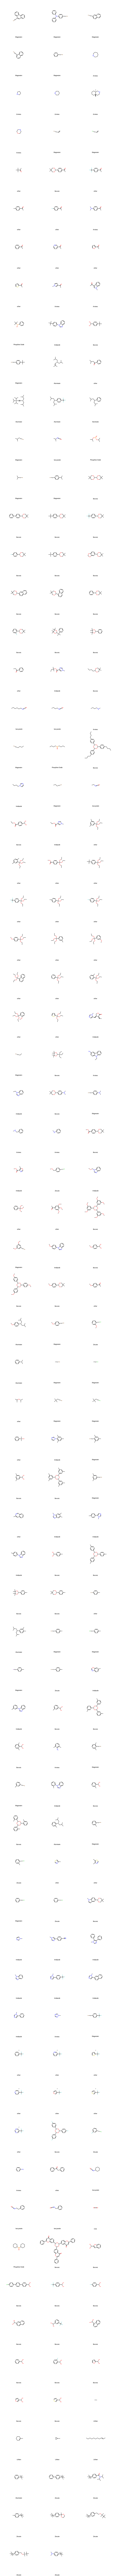

In [60]:
unik_lig = np.unique(df["A-X effectif"])
can_unik_lig = np.unique([Chem.CanonSmiles(smi) for smi in unik_lig])

counts= []
for typ in np.unique(ax_type(can_unik_lig)):
    c = ax_type(can_unik_lig).count(typ), typ
    counts.append(c)
    
print(counts)

mols = [Chem.MolFromSmiles(smi)  for smi in can_unik_lig]

types = ax_type(can_unik_lig)
Chem.Draw.MolsToGridImage(mols, legends = ax_type(can_unik_lig), maxMols = 200, subImgSize=(400, 400))

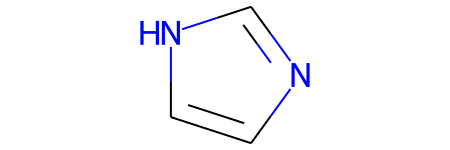

In [33]:
Chem.MolFromSmiles('N1=CNC=C1')

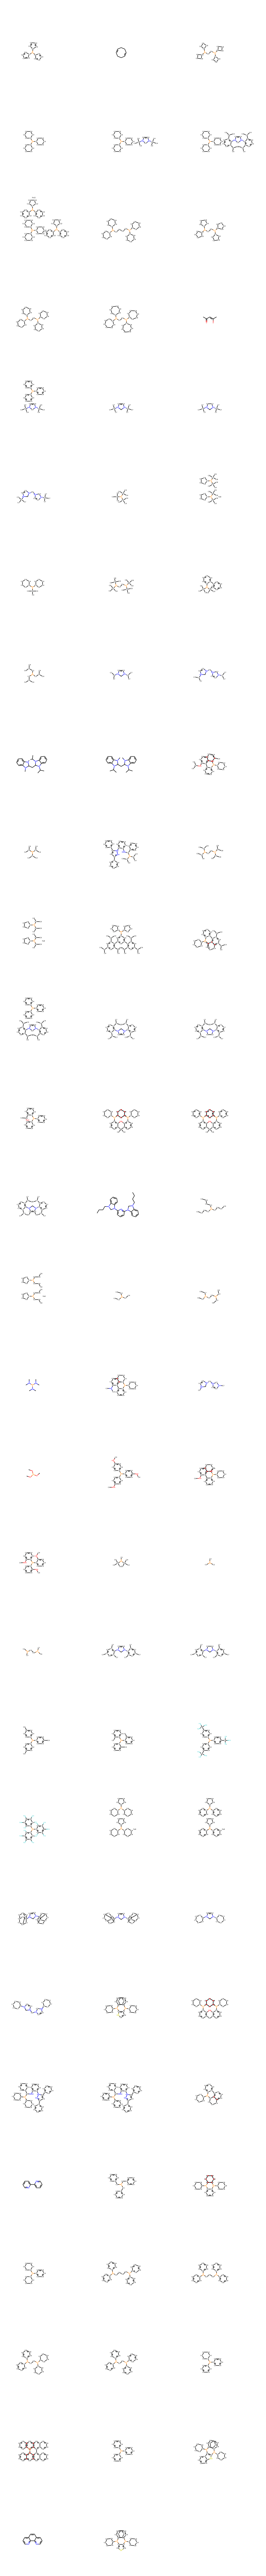

In [19]:
numbered_mols = []
for i, smi in enumerate(can_unik_lig):
    typ = types[i]
    if typ == 'Phos':
        num_mol = number_Phos(smi)
    elif typ == 'DiPhos':
        num_mol = number_DiPhos(smi)
    elif typ == 'NHC':
        num_mol = number_NHC(smi)
    else:
        num_mol = Chem.MolFromSmiles(smi)
    numbered_mols.append(num_mol)

Chem.Draw.MolsToGridImage(numbered_mols, maxMols = 200, subImgSize=(400, 400))

In [21]:
num_smis = [Chem.MolToSmiles(i) for i in numbered_mols]

In [22]:
num_df  = pd.DataFrame({'react' : can_unik_lig,
                        'C0C7_num' : num_smis},
                        columns = ['react', 'C0C7_num'])

In [23]:
num_df

,react,C0C7_num
0,C1=CC(P(C2C=CC=C2)C2C=CC=C2)C=C1,P([CH:1]1[CH:4]=[CH:4][CH:4]=[CH:4]1)([CH:2]1[...
1,C1=CCCC=CCC1,C1=CCCC=CCC1
2,C1CC(P(CCP(C2CCC2)C2CCC2)C2CCC2)C1,P([CH:2]1[CH2:8][CH2:8][CH2:8]1)([CH2:3][CH2:5...
3,C1CCC(P(C2CCCCC2)C2CCCCC2)CC1,P([CH:1]1[CH2:4][CH2:4][CH2:4][CH2:4][CH2:4]1)...
4,C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(C)(C)N1C=CN(C...,P([CH:1]1[CH2:4][CH2:4][CH2:4][CH2:4][CH2:4]1)...
...,...,...
81,c1ccc(P(c2ccccc2)c2ccc3ccccc3c2-c2c(P(c3ccccc3...,P([c:2]1[cH:8][cH:8][cH:8][cH:8][cH:8]1)([c:3]...
82,c1ccc(P(c2ccccc2)c2ccccc2)cc1,P([c:1]1[cH:4][cH:4][cH:4][cH:4][cH:4]1)([c:2]...
83,c1ccc2c(P(C3CCCCC3)C3CCCCC3)c(P(C3CCCCC3)C3CCC...,P([c:2]1[c:5]([P:1]([CH:6]2[CH2:8][CH2:8][CH2:...
84,c1cnc2c(c1)ccc1cccnc12,c1cnc2c(c1)ccc1cccnc12


In [24]:
num_df.to_csv("../data_csv/num_ligands.csv", sep=',',index=False)

In [13]:
smi_L_type(phos[0])

'Phos'

In [57]:
m= Chem.MolFromSmiles('CC[Al](CC)CC')
m.HasSubstructMatch(Chem.MolFromSmiles('C[Al](C)C'))

True